In [3]:
# khai báo thư viện
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.ticker import ScalarFormatter

from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

# các lớp để xây dựng mô hình
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense

# kiểm tra độ chính xác của các mô hình
from sklearn.metrics import r2_score # đo mức độ phù hợp
from sklearn.metrics import mean_absolute_error # đo sai số tuyệt đối trung bình
from sklearn.metrics import mean_absolute_percentage_error # đo phần trăm sai số tuyệt đối trung bình

In [4]:
df = pd.read_csv("4.2.3 (TARGET) (live & his) CMG_detail_transactions_processed.csv")
df.head()

,StockID,Date,Total Volume,Total Value,Market Cap,Closing Price,Price Change,Price Change %,Matched Volume,Matched Value
0,CMG,12/03/2025,"1,808,600","77,169","8,927,459","42,250",-850,-1.97,"1,808,600","77,169"
1,CMG,11/03/2025,"1,602,500","69,081","9,107,065","43,100",-850,-1.93,"1,602,500","69,081"
2,CMG,10/03/2025,"910,000","40,111","9,286,670","43,950",-400,-0.90,"910,000","40,111"
3,CMG,07/03/2025,"596,200","26,542","9,371,191","44,350",-250,-0.56,"596,200","26,542"
4,CMG,06/03/2025,"1,053,600","46,780","9,425,746","44,600",600,1.36,"1,053,600","46,780"


In [5]:
df.Date = pd.to_datetime(df.Date, format = "%d/%m/%Y")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   StockID         250 non-null    object        
 1   Date            250 non-null    datetime64[ns]
 2   Total Volume    250 non-null    object        
 3   Total Value     250 non-null    object        
 4   Market Cap      250 non-null    object        
 5   Closing Price   250 non-null    object        
 6   Price Change    250 non-null    object        
 7   Price Change %  250 non-null    float64       
 8   Matched Volume  250 non-null    object        
 9   Matched Value   250 non-null    object        
dtypes: datetime64[ns](1), float64(1), object(8)
memory usage: 19.7+ KB


In [6]:
df['Price Change %'] = df['Price Change %']/100

In [7]:
def convert_columns_to_int(df, cols):
    df[cols] = (
        df[cols]
        .astype(str)
        .replace(',', '', regex=True)
        .astype(float)
        .round()
        .astype(int)
    )
    return df

In [8]:
cols_to_convert = ['Total Volume', 'Total Value', 'Market Cap','Closing Price', 'Price Change', 'Matched Volume','Matched Value']
df = convert_columns_to_int(df, cols_to_convert)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   StockID         250 non-null    object        
 1   Date            250 non-null    datetime64[ns]
 2   Total Volume    250 non-null    int32         
 3   Total Value     250 non-null    int32         
 4   Market Cap      250 non-null    int32         
 5   Closing Price   250 non-null    int32         
 6   Price Change    250 non-null    int32         
 7   Price Change %  250 non-null    float64       
 8   Matched Volume  250 non-null    int32         
 9   Matched Value   250 non-null    int32         
dtypes: datetime64[ns](1), float64(1), int32(7), object(1)
memory usage: 12.8+ KB


In [9]:
df = df.sort_values(by='Date', ascending=True)
df

,StockID,Date,Total Volume,Total Value,Market Cap,Closing Price,Price Change,Price Change %,Matched Volume,Matched Value
249,CMG,2024-03-12,588800,23350,7715096,40600,1400,0.0357,528800,20998
248,CMG,2024-03-13,486500,20274,7971632,41950,1350,0.0333,386500,16214
247,CMG,2024-03-14,313300,12863,7914624,41650,-300,-0.0072,247300,10157
246,CMG,2024-03-15,319900,13079,7886120,41500,-150,-0.0036,219900,8914
245,CMG,2024-03-18,277300,11207,7781605,40950,-550,-0.0133,205300,8255
...,...,...,...,...,...,...,...,...,...,...
4,CMG,2025-03-06,1053600,46780,9425746,44600,600,0.0136,1053600,46780
3,CMG,2025-03-07,596200,26542,9371191,44350,-250,-0.0056,596200,26542
2,CMG,2025-03-10,910000,40111,9286670,43950,-400,-0.0090,910000,40111
1,CMG,2025-03-11,1602500,69081,9107065,43100,-850,-0.0193,1602500,69081


In [10]:
df = df.set_index('Date')
df

,StockID,Total Volume,Total Value,Market Cap,Closing Price,Price Change,Price Change %,Matched Volume,Matched Value
Date,,,,,,,,,
2024-03-12,CMG,588800,23350,7715096,40600,1400,0.0357,528800,20998
2024-03-13,CMG,486500,20274,7971632,41950,1350,0.0333,386500,16214
2024-03-14,CMG,313300,12863,7914624,41650,-300,-0.0072,247300,10157
2024-03-15,CMG,319900,13079,7886120,41500,-150,-0.0036,219900,8914
2024-03-18,CMG,277300,11207,7781605,40950,-550,-0.0133,205300,8255
...,...,...,...,...,...,...,...,...,...
2025-03-06,CMG,1053600,46780,9425746,44600,600,0.0136,1053600,46780
2025-03-07,CMG,596200,26542,9371191,44350,-250,-0.0056,596200,26542
2025-03-10,CMG,910000,40111,9286670,43950,-400,-0.0090,910000,40111


In [11]:
df_num = df.select_dtypes(include=['int64', 'float64'])
df_obj = df.select_dtypes(['object'])

C:\Users\Admin\AppData\Local\Temp\ipykernel_2212\1243517510.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=12)


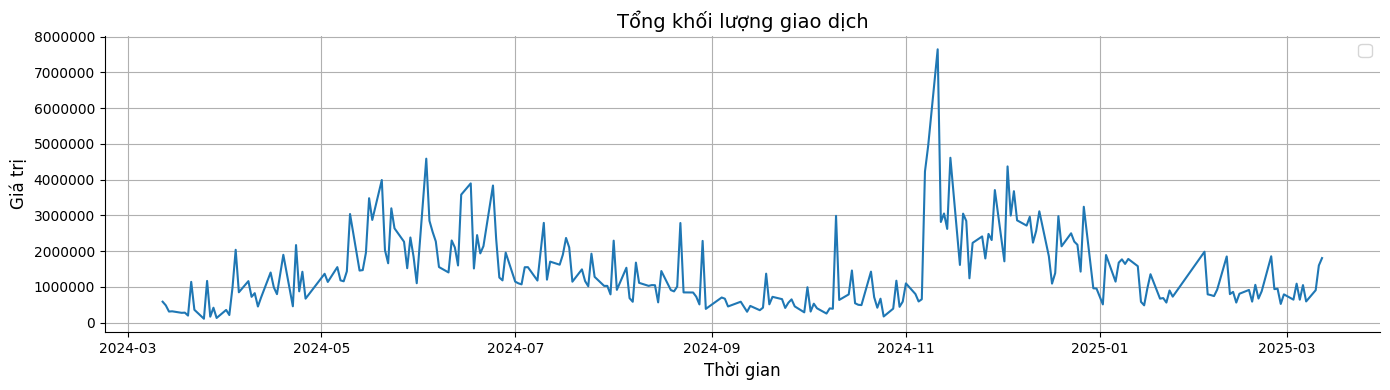

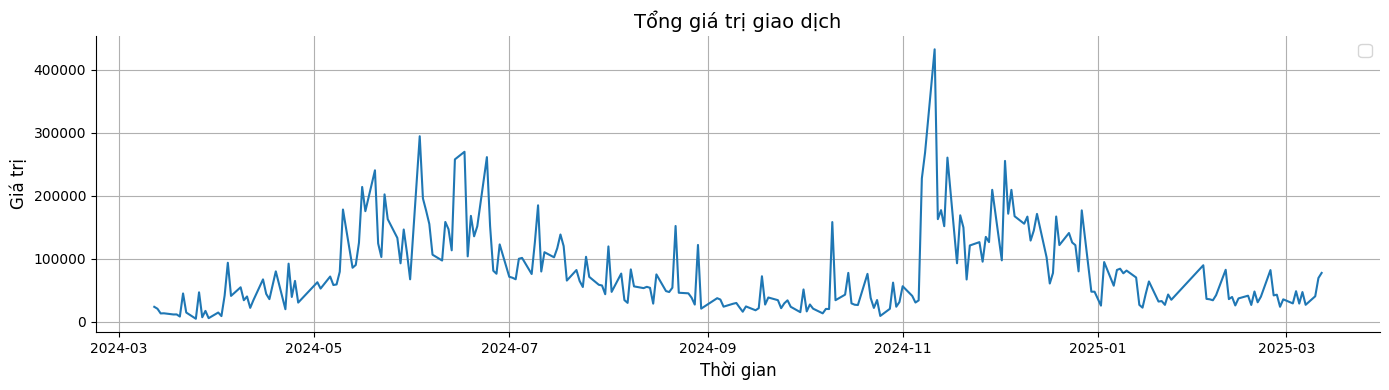

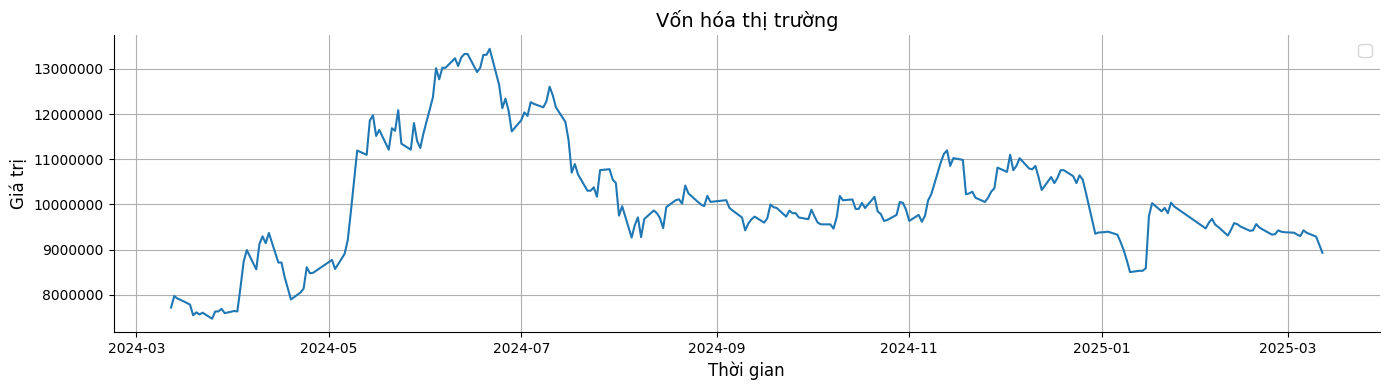

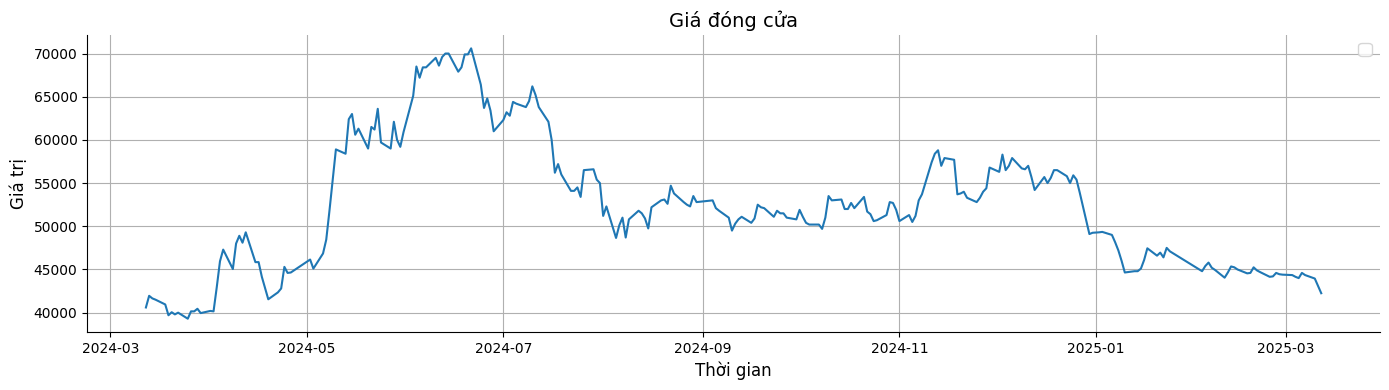

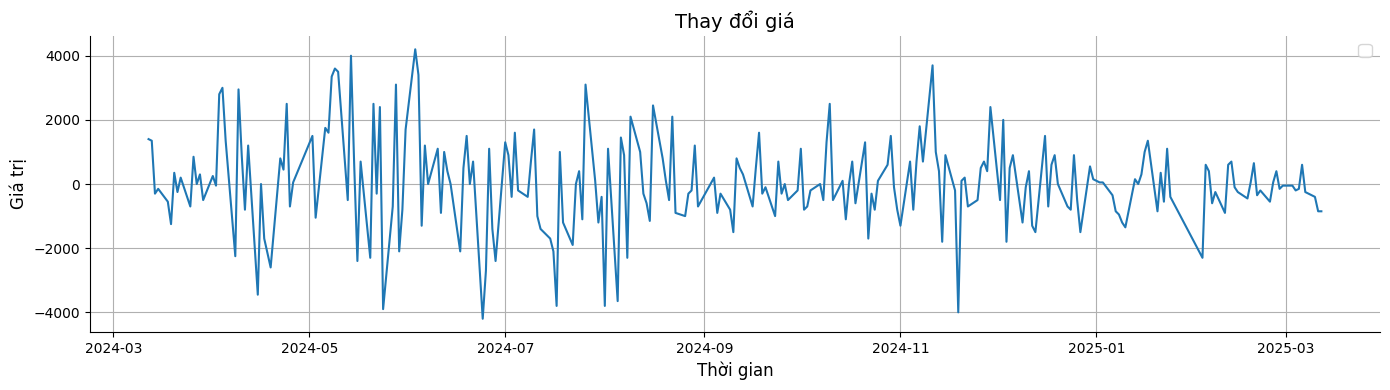

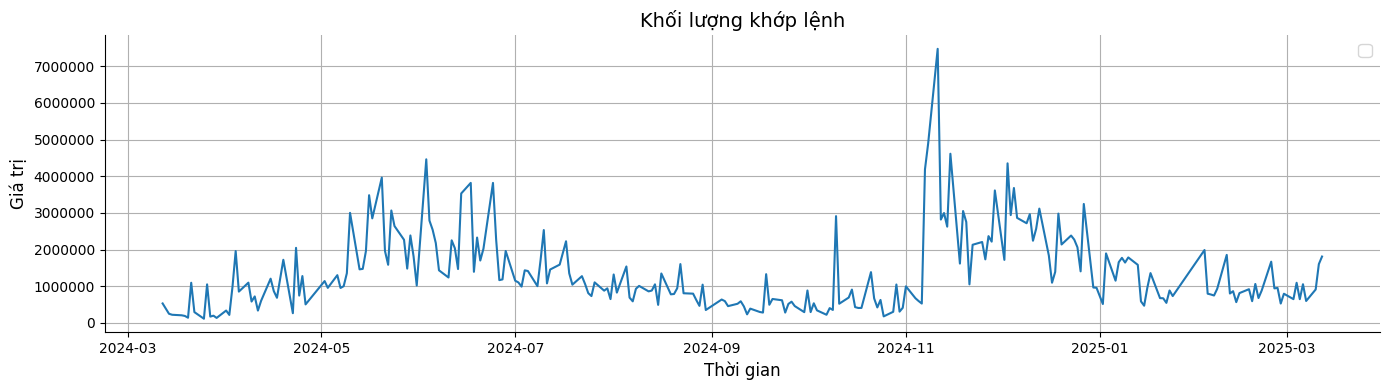

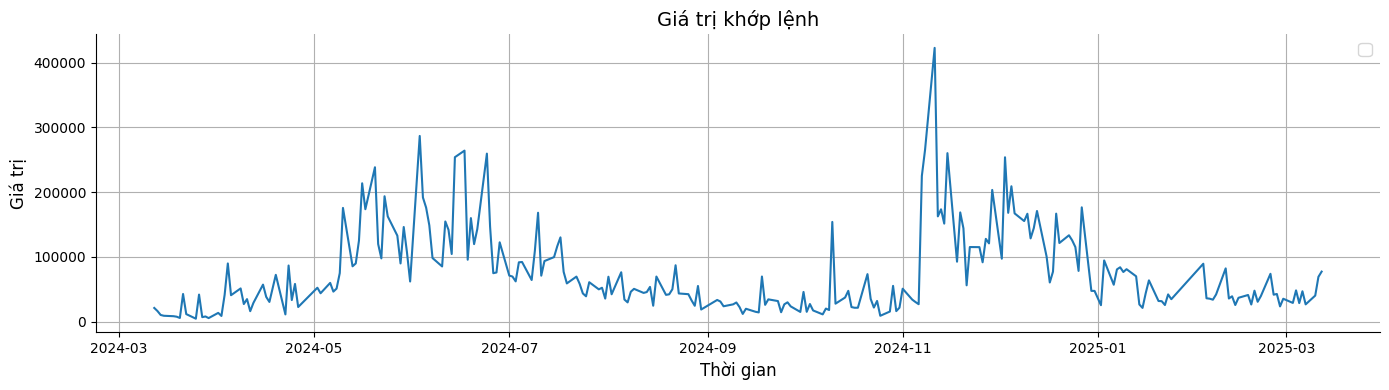

In [12]:
fields_vn = {
    'Total Volume': 'Tổng khối lượng giao dịch',
    'Total Value': 'Tổng giá trị giao dịch',
    'Market Cap': 'Vốn hóa thị trường',
    'Closing Price': 'Giá đóng cửa',
    'Price Change': 'Thay đổi giá',
    'Matched Volume': 'Khối lượng khớp lệnh',
    'Matched Value': 'Giá trị khớp lệnh'
}

for field, label in fields_vn.items():
    plt.figure(figsize=(14, 4))
    plt.plot(df[field])
    plt.title(label, fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)

    ax = plt.gca()

    # Ẩn viền trên và bên phải
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Hiển thị số nguyên, không dạng e^
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=False))
    ax.ticklabel_format(style='plain', axis='y')

    plt.xlabel("Thời gian", fontsize=12)
    plt.ylabel("Giá trị", fontsize=12)

    plt.tight_layout()
    plt.show()

In [13]:
ma_day = [10,20,50]

for ma in ma_day:
  df[f'MA_{ma}'] = df['Closing Price'].rolling(ma).mean()

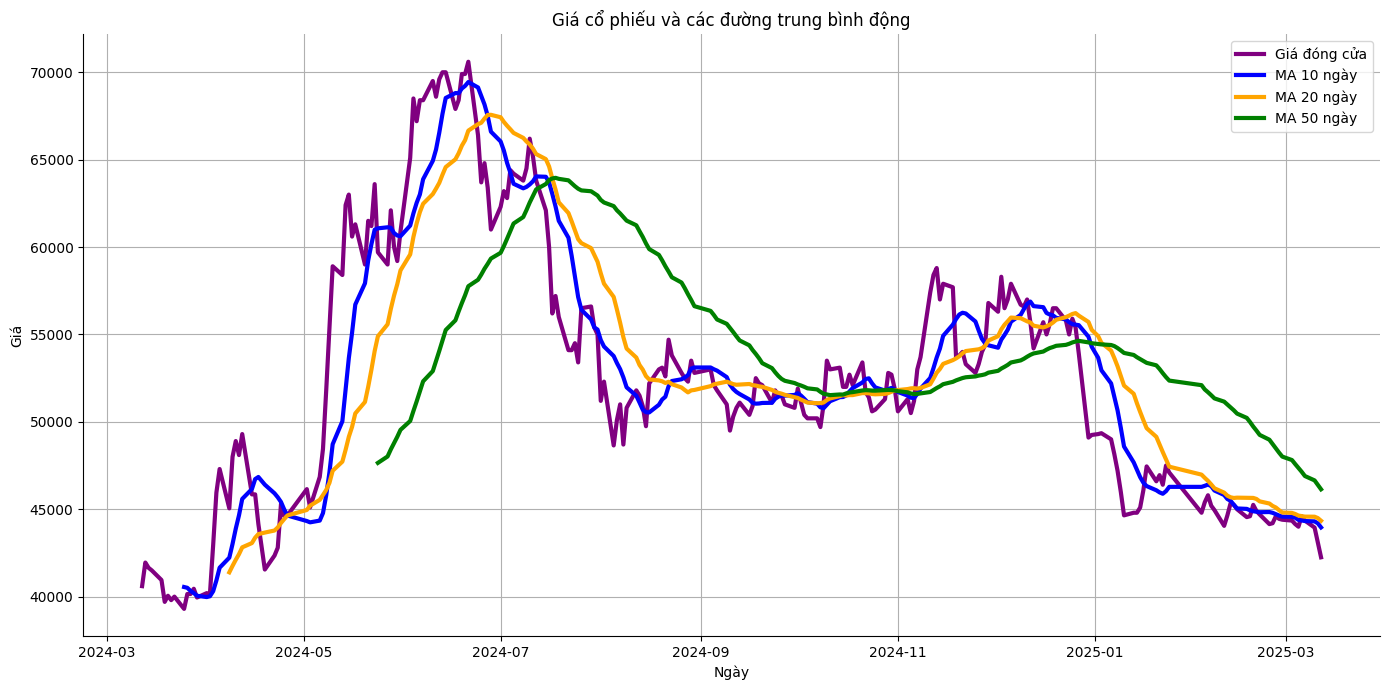

In [14]:
plt.figure(figsize=(14, 7))

# giá đóng cửa
plt.plot(df['Closing Price'], label='Giá đóng cửa', color='purple', linewidth=3)
# các đường MA
plt.plot(df['MA_10'], label='MA 10 ngày', color='blue', linewidth=3)
plt.plot(df['MA_20'], label='MA 20 ngày', color='orange', linewidth=3)
plt.plot(df['MA_50'], label='MA 50 ngày', color='green', linewidth=3)
plt.title('Giá cổ phiếu và các đường trung bình động')
plt.xlabel('Ngày')
plt.ylabel('Giá')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Ẩn viền trên và phải
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

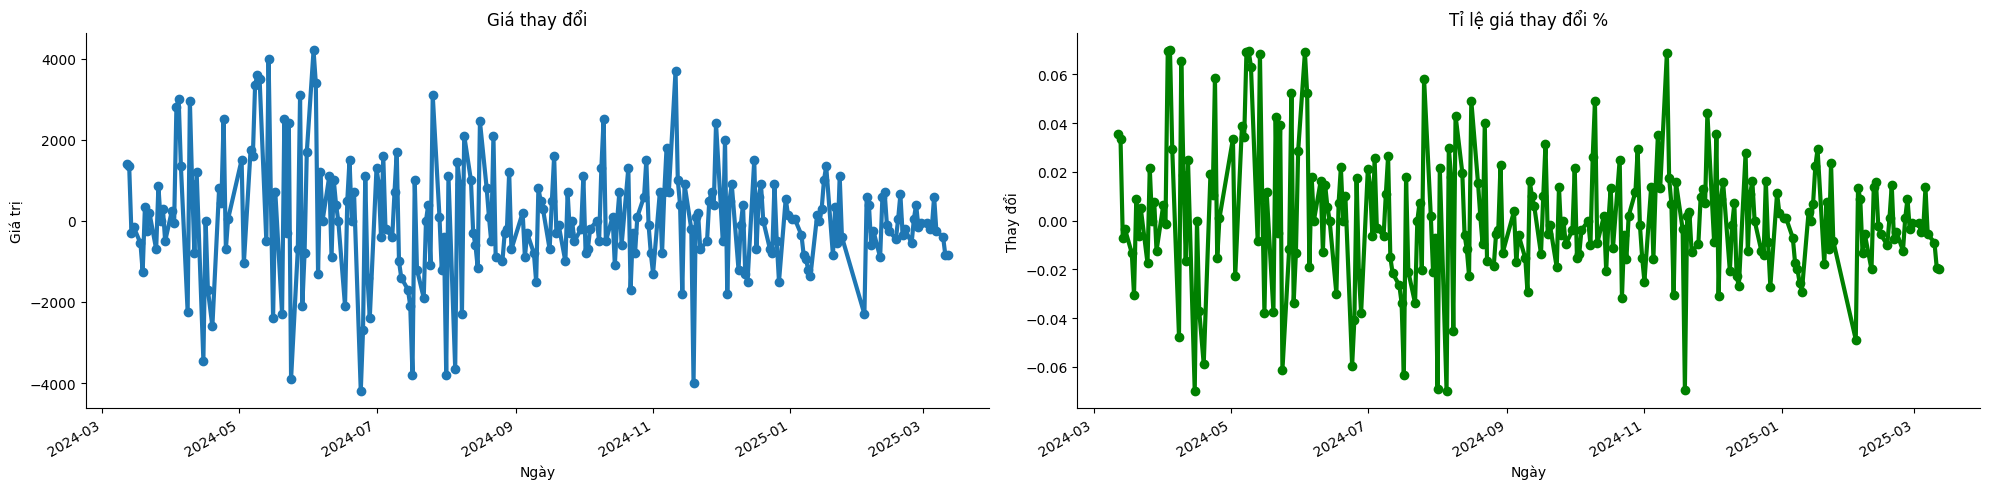

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,5))

# Biểu đồ 1: Price Change
df['Price Change'].plot(ax=axes[0], marker='o', linewidth=3)
axes[0].set_title('Giá thay đổi')
axes[0].set_xlabel('Ngày')
axes[0].set_ylabel('Giá trị')

# Ẩn viền trên và phải cho biểu đồ 1
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)

# Biểu đồ 2: Price Change %
df['Price Change %'].plot(ax=axes[1], marker='o', color='green', linewidth=3)
axes[1].set_title('Tỉ lệ giá thay đổi %')
axes[1].set_xlabel('Ngày')
axes[1].set_ylabel('Thay đổi')

# Ẩn viền trên và phải cho biểu đồ 2
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

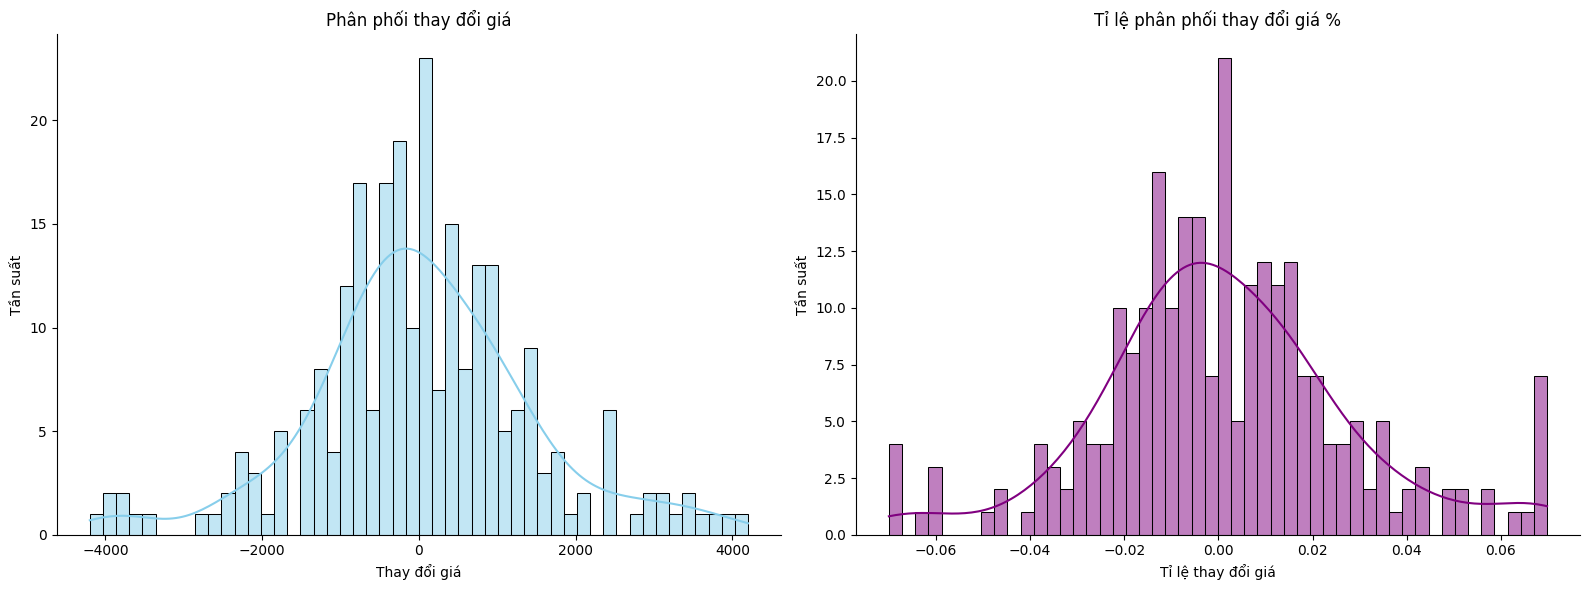

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Subplot 1: Price Change
sns.histplot(data=df, x='Price Change', bins=50, kde=True, color='skyblue', ax=axes[0])
axes[0].set_title('Phân phối thay đổi giá')
axes[0].set_xlabel('Thay đổi giá')
axes[0].set_ylabel('Tần suất')


# Ẩn viền trên và phải cho biểu đồ 2
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)

# Subplot 2: Price Change %
sns.histplot(data=df, x='Price Change %', bins=50, kde=True, color='purple', ax=axes[1])
axes[1].set_title('Tỉ lệ phân phối thay đổi giá %')
axes[1].set_xlabel('Tỉ lệ thay đổi giá')
axes[1].set_ylabel('Tần suất')


# Ẩn viền trên và phải cho biểu đồ 2
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

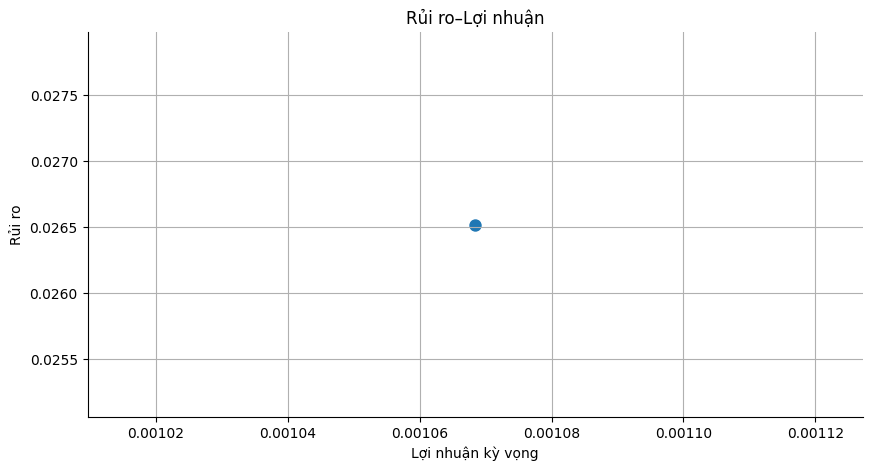

In [17]:
area = np.pi*20

plt.figure(figsize=(10,5))
plt.scatter(df['Price Change %'].mean(), df['Price Change %'].std(), s=area)
plt.title('Rủi ro–Lợi nhuận')
plt.xlabel('Lợi nhuận kỳ vọng')
plt.ylabel('Rủi ro')

# Ẩn viền trên và phải
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.grid()
plt.show()

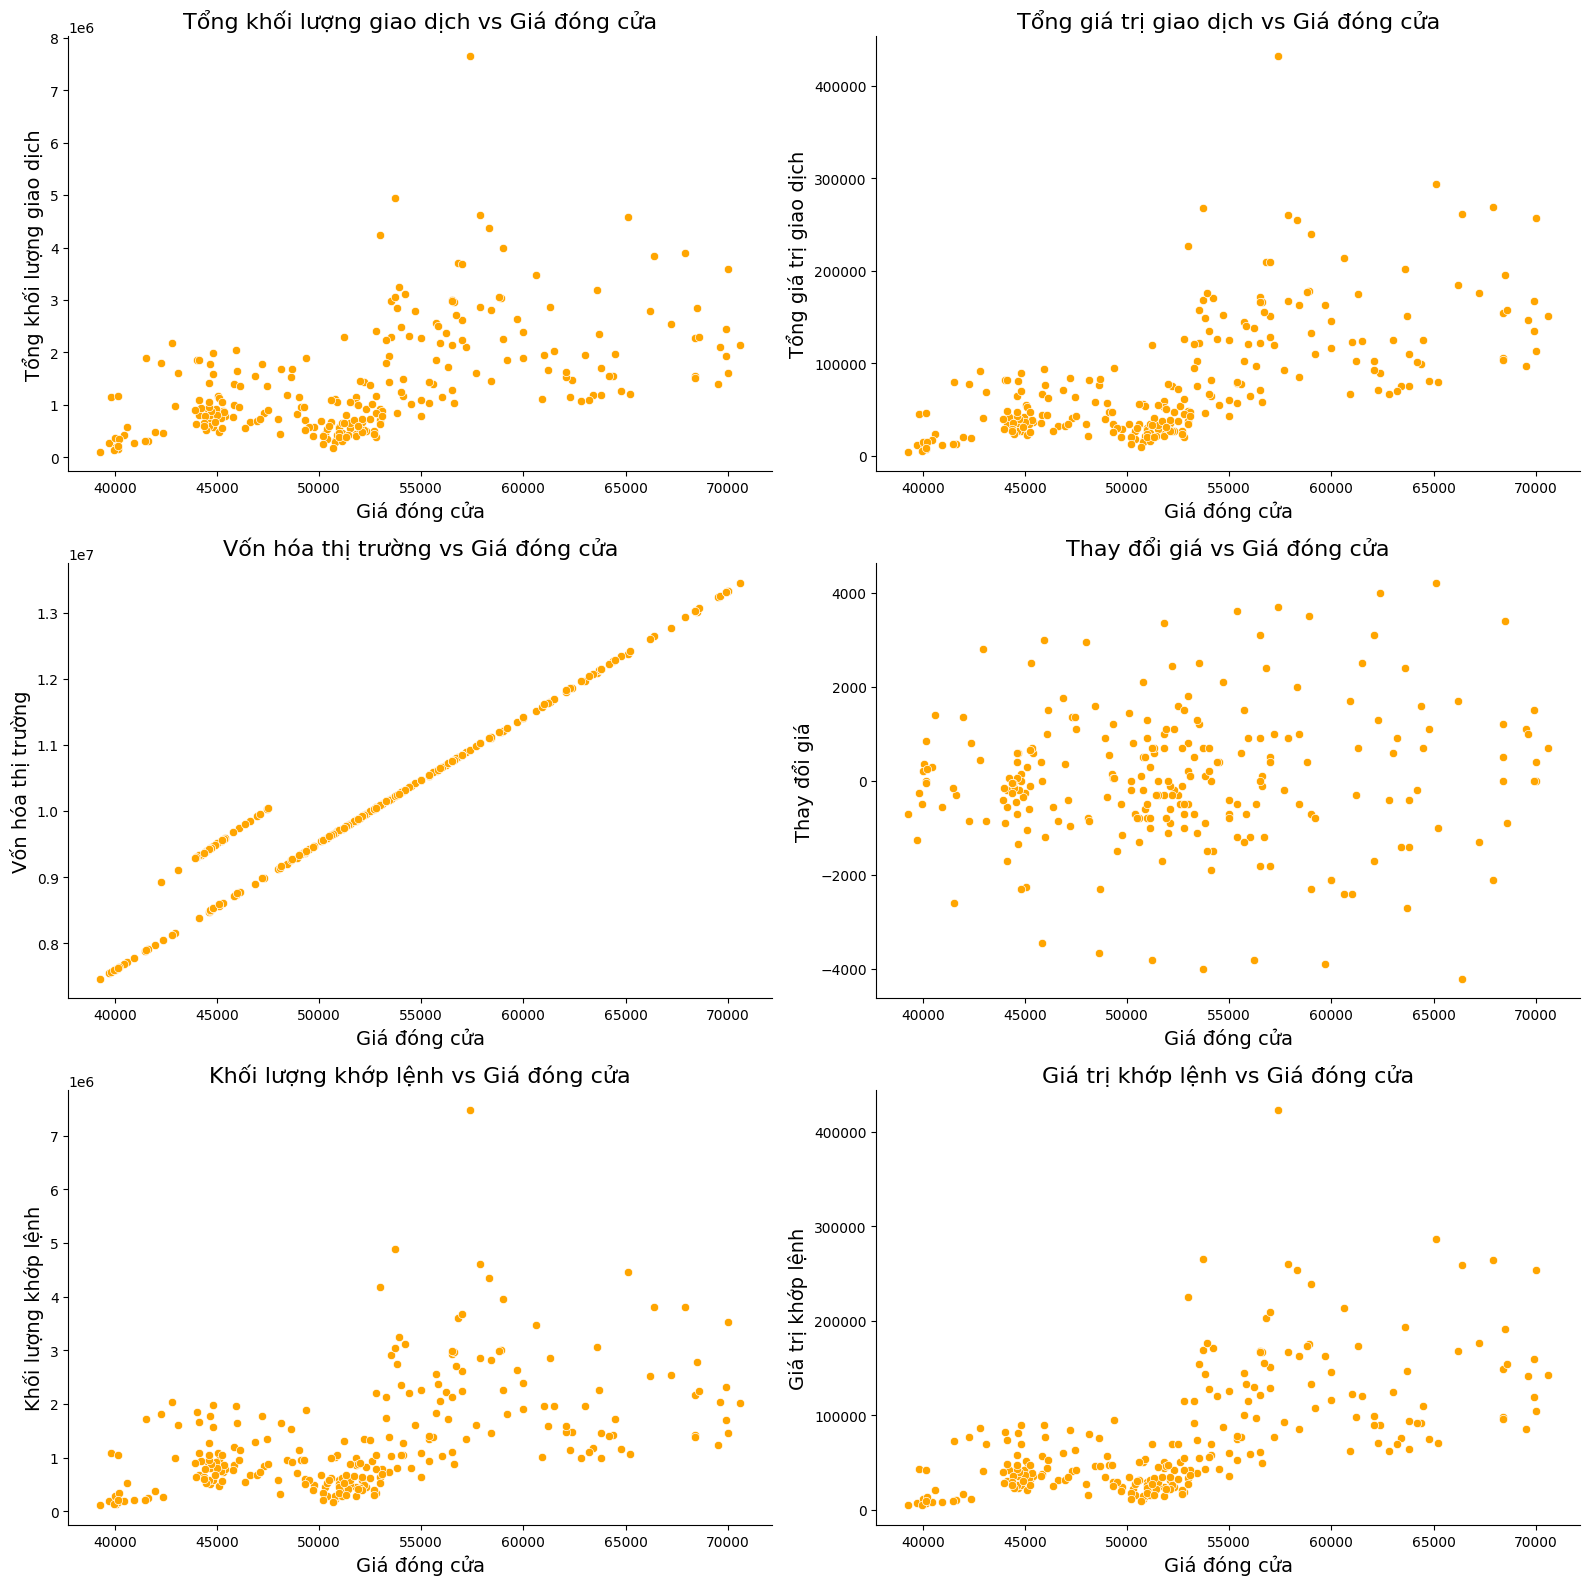

In [18]:
features = [
    'Total Volume',
    'Total Value',
    'Market Cap',
    'Price Change',
    'Matched Volume',
    'Matched Value'
]

# Từ điển chuyển đổi sang tiếng Việt
fields_vn = {
    'Total Volume': 'Tổng khối lượng giao dịch',
    'Total Value': 'Tổng giá trị giao dịch',
    'Market Cap': 'Vốn hóa thị trường',
    'Closing Price': 'Giá đóng cửa',
    'Price Change': 'Thay đổi giá',
    'Matched Volume': 'Khối lượng khớp lệnh',
    'Matched Value': 'Giá trị khớp lệnh'
}

sns.set_palette('PiYG')
plt.figure(figsize=(16, 26))

for idx, column in enumerate(features):
    plt.subplot(5, 2, idx + 1)
    sns.scatterplot(
        x=df['Closing Price'],
        y=df[column],
        data=df,
        color='orange'
    )
    plt.title(f'{fields_vn.get(column, column)} vs Giá đóng cửa', fontsize=16)
    plt.xlabel('Giá đóng cửa', fontsize=14)
    plt.ylabel(fields_vn.get(column, column), fontsize=14)
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

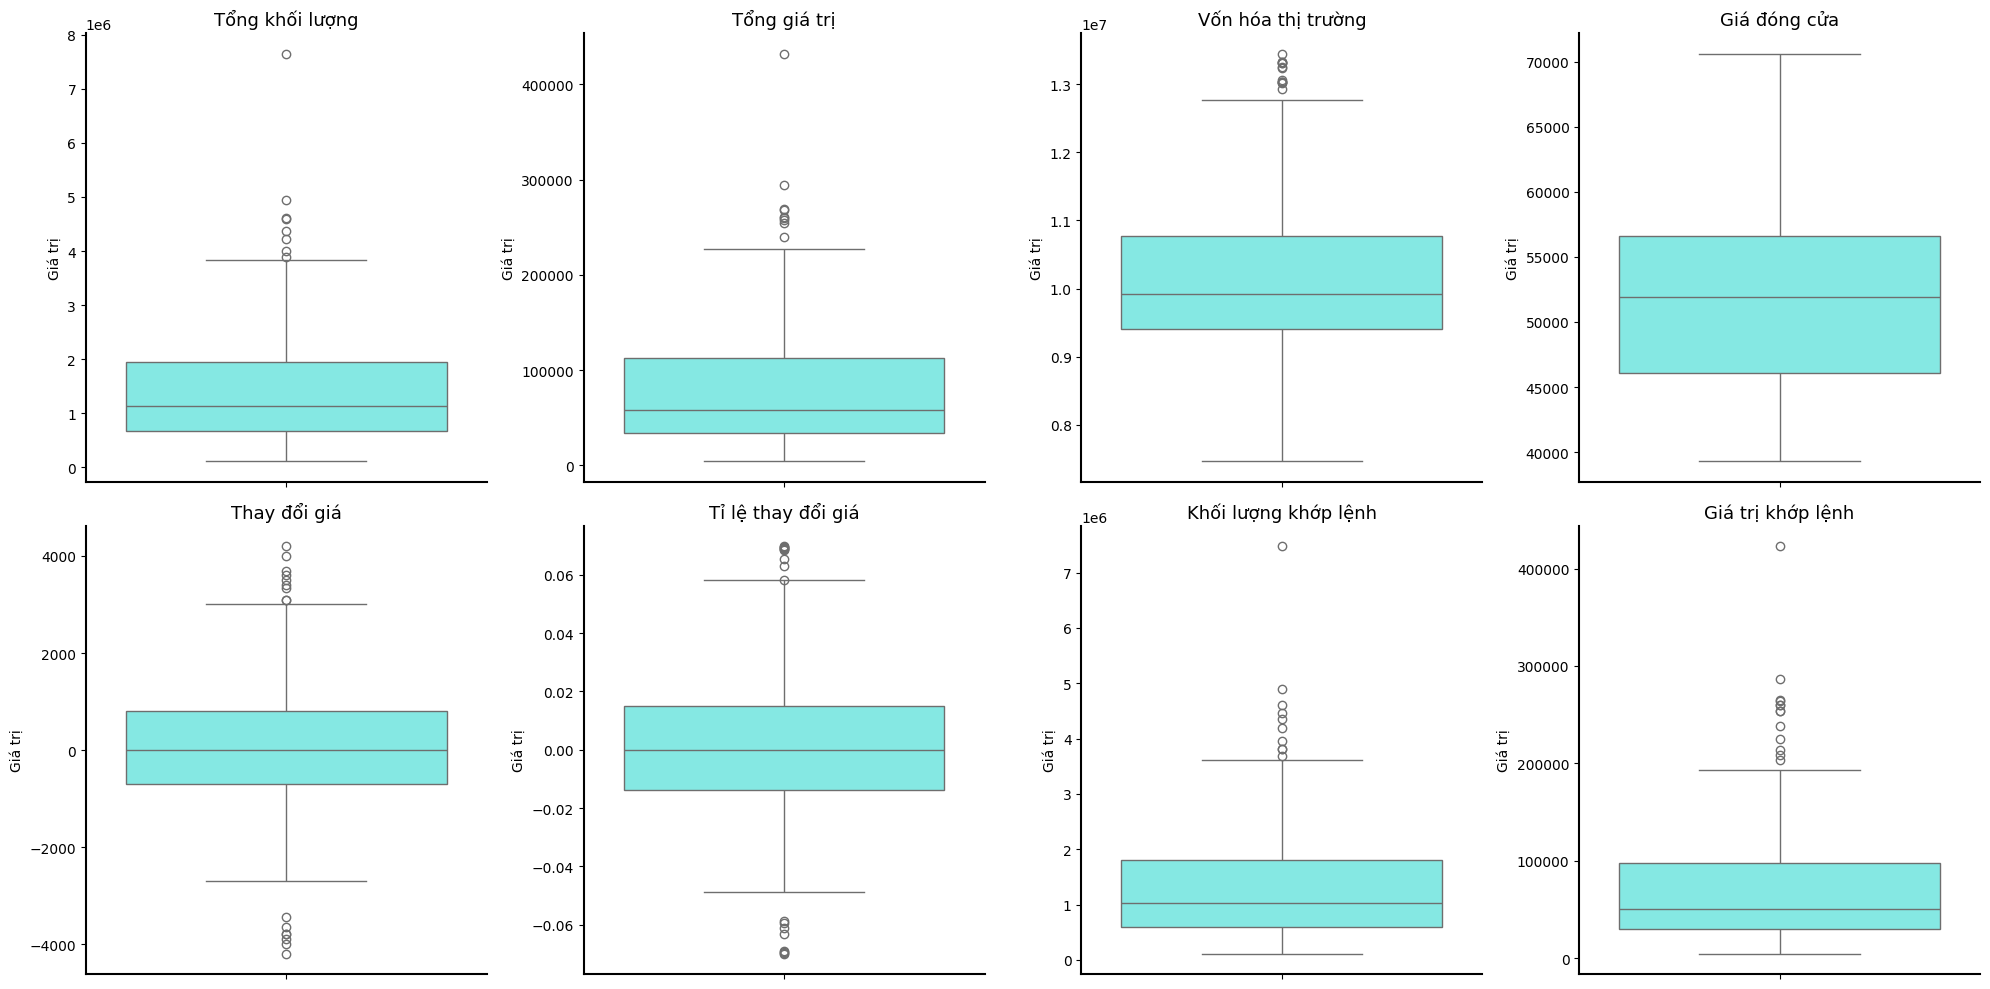

In [19]:
# Danh sách cột
features = ['Total Volume', 'Total Value', 'Market Cap', 'Closing Price',
            'Price Change', 'Price Change %', 'Matched Volume', 'Matched Value']

# Ánh xạ tên cột sang tiếng Việt
fields_vn = {
    'Total Volume': 'Tổng khối lượng',
    'Total Value': 'Tổng giá trị',
    'Market Cap': 'Vốn hóa thị trường',
    'Closing Price': 'Giá đóng cửa',
    'Price Change': 'Thay đổi giá',
    'Price Change %': 'Tỉ lệ thay đổi giá',
    'Matched Volume': 'Khối lượng khớp lệnh',
    'Matched Value': 'Giá trị khớp lệnh'
}

# Tạo lưới 2 hàng, 4 cột
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
axes = axes.flatten()

for i, col in enumerate(features):
    sns.boxplot(y=df[col], ax=axes[i], color='#75f8f2')
    axes[i].set_title(f'{fields_vn.get(col, col)}', fontsize=13)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Giá trị')

    # Ẩn viền trên và phải
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)

    for spine in ['left', 'bottom']:
        axes[i].spines[spine].set_linewidth(1.5)
        axes[i].spines[spine].set_edgecolor('black')

plt.tight_layout()
plt.show()

# Dự báo giá chứng khoán

In [20]:
data = df[['Closing Price']]
dataset = data.values

Xét các yếu tố liên quan

<Figure size 1500x500 with 0 Axes>

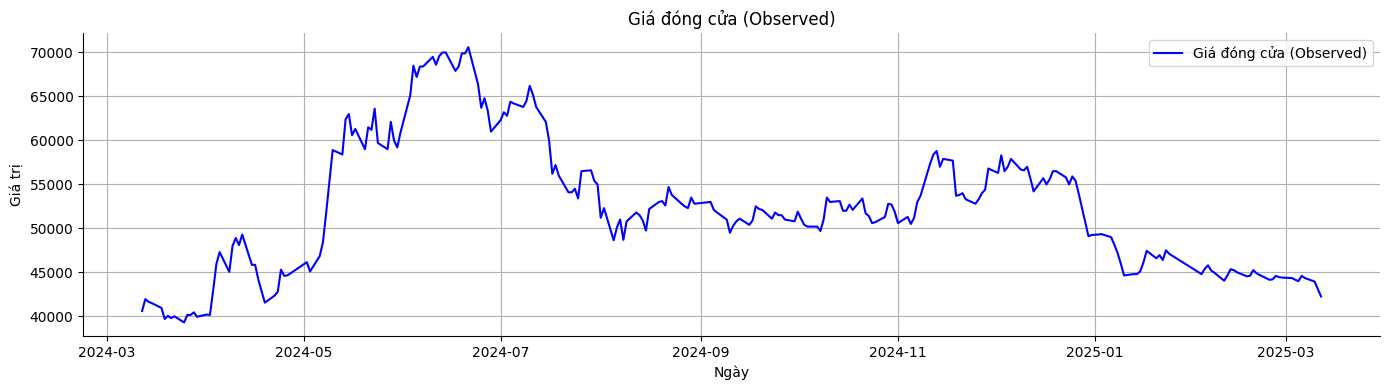

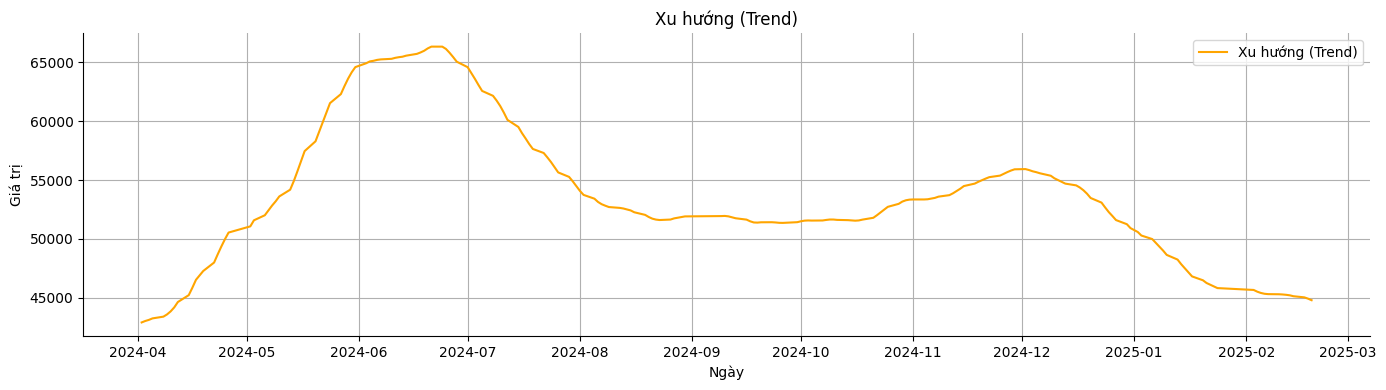

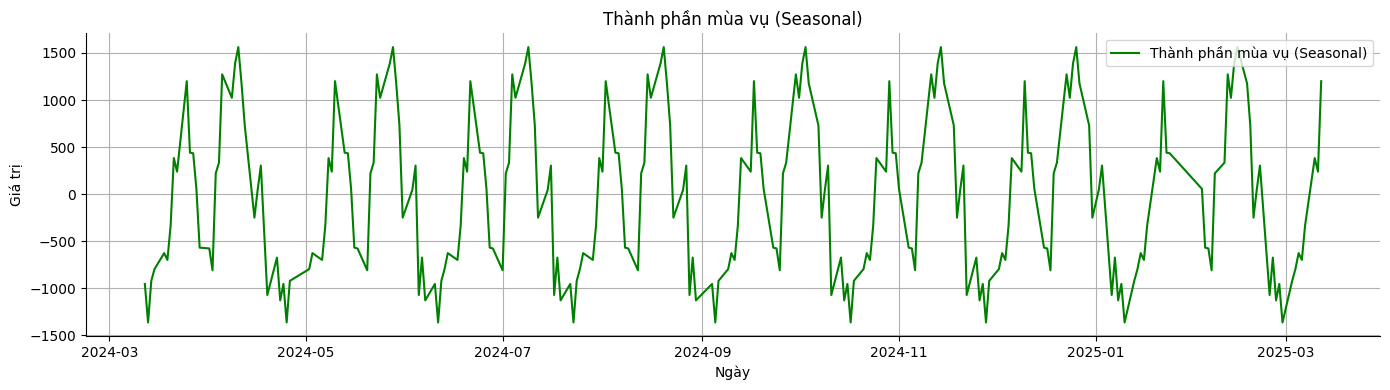

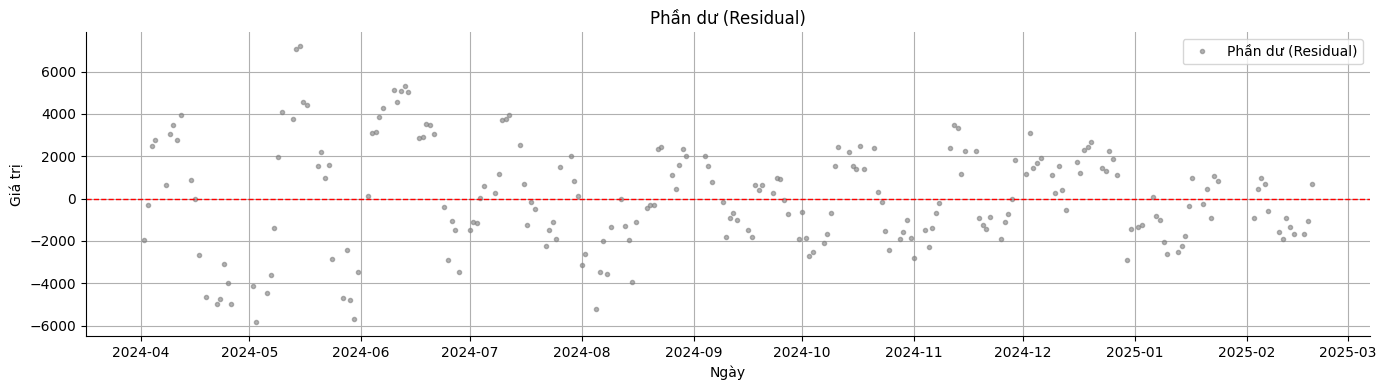

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose

plt.figure(figsize=(15,5))
# Phân tích chuỗi thời gian
decomposeResult = seasonal_decompose(data['Closing Price'], model='additive', period=30)

# Danh sách thành phần và thiết lập hiển thị
components = {
    'Observed': ('Giá đóng cửa (Observed)', decomposeResult.observed, 'blue'),
    'Trend': ('Xu hướng (Trend)', decomposeResult.trend, 'orange'),
    'Seasonal': ('Thành phần mùa vụ (Seasonal)', decomposeResult.seasonal, 'green'),
    'Residual': ('Phần dư (Residual)', decomposeResult.resid, 'gray')
}

for key, (title, series, color) in components.items():
    plt.figure(figsize=(14, 4))
    if key == 'Residual':
        plt.plot(series, label=title, linestyle='', marker='o', markersize=3, alpha=0.6, color=color)
        plt.axhline(0, color='red', linestyle='--', linewidth=1)
    else:
        plt.plot(series, label=title, color=color)

    plt.title(title)
    plt.xlabel("Ngày")
    plt.ylabel("Giá trị")
    plt.grid(True)
    plt.legend()

    plt.legend(loc='upper right')

    # Ẩn khung viền trên và phải
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.show()

Bắt đầu huấn luyện mô hình

In [52]:
training_data_len = int(np.ceil(len(dataset) * .80))

In [53]:
scaler = MinMaxScaler()
scaler_data = scaler.fit_transform(dataset)

In [54]:
train_data = scaler_data[0:training_data_len, :]
x_train, y_train = [], []
for i in range(50, len(train_data)):
    x_train.append(train_data[i-50:i, 0])
    y_train.append(train_data[i, 0])

In [55]:
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], 1))

In [56]:
# Xây dựng mô hình
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(x_train.shape[1],1)),
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [27]:
save_model = "CMG.keras"
best_model = ModelCheckpoint(save_model, monitor='loss', verbose=2, save_best_only=True, mode='auto')

# Huấn luyện
model.fit(x_train, y_train, batch_size=50, epochs=100, verbose=2, callbacks=[best_model])

Epoch 1/100

Epoch 1: loss improved from inf to 0.12820, saving model to CMG.keras
3/3 - 5s - 2s/step - loss: 0.1282
Epoch 2/100

Epoch 2: loss improved from 0.12820 to 0.04562, saving model to CMG.keras
3/3 - 1s - 224ms/step - loss: 0.0456
Epoch 3/100

Epoch 3: loss improved from 0.04562 to 0.01629, saving model to CMG.keras
3/3 - 0s - 142ms/step - loss: 0.0163
Epoch 4/100

Epoch 4: loss did not improve from 0.01629
3/3 - 0s - 136ms/step - loss: 0.0218
Epoch 5/100

Epoch 5: loss did not improve from 0.01629
3/3 - 0s - 118ms/step - loss: 0.0201
Epoch 6/100

Epoch 6: loss did not improve from 0.01629
3/3 - 0s - 131ms/step - loss: 0.0169
Epoch 7/100

Epoch 7: loss improved from 0.01629 to 0.01568, saving model to CMG.keras
3/3 - 0s - 134ms/step - loss: 0.0157
Epoch 8/100

Epoch 8: loss improved from 0.01568 to 0.01441, saving model to CMG.keras
3/3 - 0s - 153ms/step - loss: 0.0144
Epoch 9/100

Epoch 9: loss improved from 0.01441 to 0.01295, saving model to CMG.keras
3/3 - 0s - 149ms/step

In [28]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 348,101 (1.33 MB)

 Trainable params: 116,033 (453.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 232,068 (906.52 KB)

In [57]:
# Load model tốt nhất
final_model = load_model('CMG.keras')

In [58]:
# Dự đoán và đánh giá trên tập huấn luyện
y_train = scaler.inverse_transform(y_train)
y_train_predict = final_model.predict(x_train)
y_train_predict = scaler.inverse_transform(y_train_predict)

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 237ms/step


In [59]:
# Chuẩn bị dữ liệu test
test = data[len(train_data)-50:].values
test = test.reshape(-1,1)
sc_test = scaler.transform(test)

x_test = []
for i in range(50, sc_test.shape[0]):
    x_test.append(sc_test[i-50:i, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [60]:
# Dự đoán trên tập test
y_test = data[training_data_len:]
y_test_predict = final_model.predict(x_test)
y_test_predict = scaler.inverse_transform(y_test_predict)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Đánh giá mô hình

In [61]:
# Đánh giá mô hình
r2_train = r2_score(y_train, y_train_predict)
mae_train = mean_absolute_error(y_train, y_train_predict)
mape_train = mean_absolute_percentage_error(y_train, y_train_predict)

r2_test = r2_score(y_test, y_test_predict)
mae_test = mean_absolute_error(y_test, y_test_predict)
mape_test = mean_absolute_percentage_error(y_test, y_test_predict)

print(f"MAE: {mae_train:.4f}, MAPE: {mape_train:.4f}")
print(f"MAE: {mae_test:.4f}, MAPE: {mape_test:.4f}")

MAE: 1823.9131, MAPE: 0.0322
MAE: 2445.6220, MAPE: 0.0532


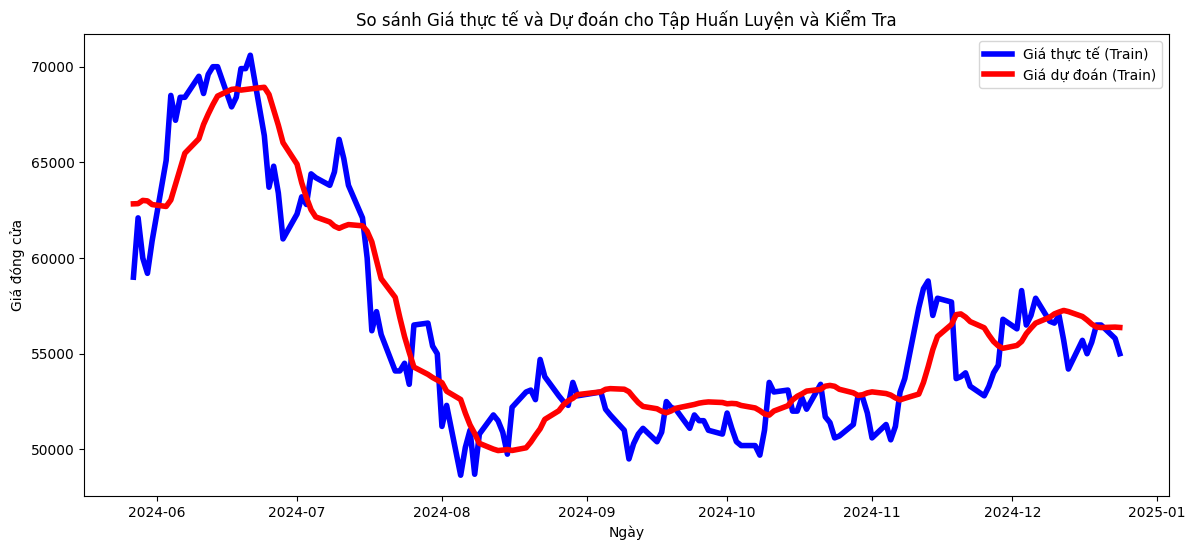

In [62]:
# Tạo lại trục x cho tập huấn luyện (train) sao cho có số lượng phần tử phù hợp
train_dates = data[:training_data_len].index  # Lấy cột Date từ dữ liệu huấn luyện
test_dates = data[training_data_len:].index   # Lấy cột Date từ dữ liệu kiểm tra

# Vẽ biểu đồ cho tập huấn luyện (train) và kiểm tra (test)
plt.figure(figsize=(14, 6))

# Vẽ giá thực tế cho tập huấn luyện (train)
plt.plot(train_dates[50:], y_train, color='blue', label='Giá thực tế (Train)', linewidth=4)  # Giá thực tế (train)
plt.plot(train_dates[50:], y_train_predict, color='red', label='Giá dự đoán (Train)', linewidth=4)  # Giá dự đoán (train)

# Thiết lập tiêu đề, trục và hiển thị thêm trục y là giá trị đóng cửa
plt.title('So sánh Giá thực tế và Dự đoán cho Tập Huấn Luyện và Kiểm Tra')
plt.xlabel('Ngày')
plt.ylabel('Giá đóng cửa')
plt.legend()


# Hiển thị biểu đồ
plt.show()

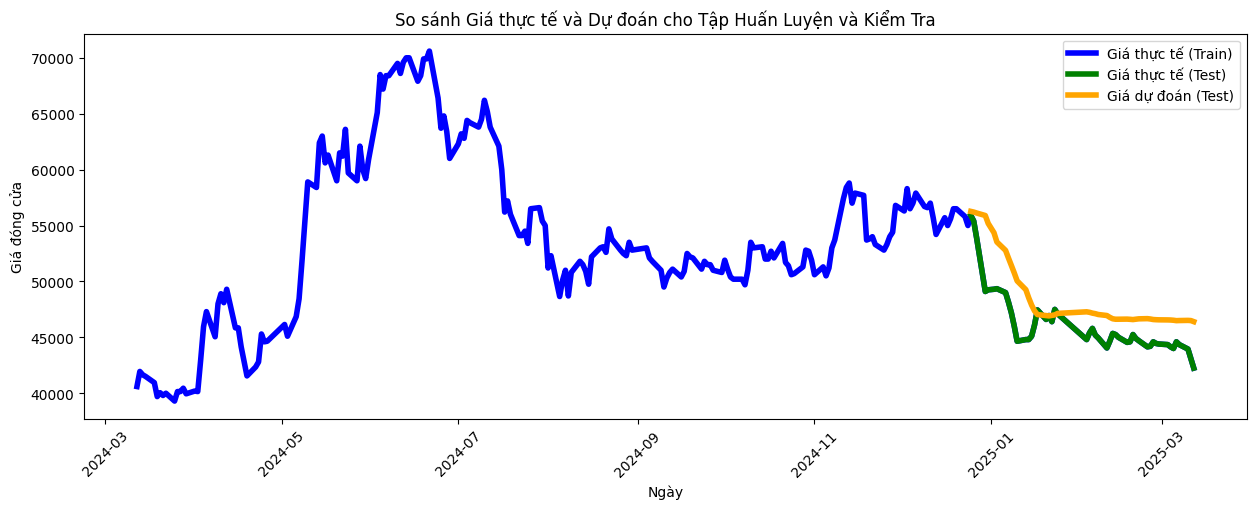

In [63]:
# Tạo lại trục x cho tập huấn luyện (train) sao cho có số lượng phần tử phù hợp
train_dates = data[:training_data_len].index  # Lấy cột Date từ dữ liệu huấn luyện
test_dates = data[training_data_len:].index   # Lấy cột Date từ dữ liệu kiểm tra

plt.figure(figsize=(15,5))
# Vẽ giá thực tế cho tập kiểm tra (test)
plt.plot(data.index, data['Closing Price'], color='blue', label='Giá thực tế (Train)', linewidth=4)  # Giá thực tế (test)
plt.plot(test_dates, y_test, color='green', label='Giá thực tế (Test)', linewidth=4)  # Giá thực tế (test)
plt.plot(test_dates, y_test_predict, color='orange', label='Giá dự đoán (Test)', linewidth=4)  # Giá dự đoán (test)

# Thiết lập tiêu đề, trục và hiển thị thêm trục y là giá trị đóng cửa
plt.title('So sánh Giá thực tế và Dự đoán cho Tập Huấn Luyện và Kiểm Tra')
plt.xlabel('Ngày')
plt.ylabel('Giá đóng cửa')
plt.legend()

# Xoay trục x để dễ đọc ngày tháng
plt.xticks(rotation=45)

# Hiển thị biểu đồ
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
            Predicted Closing Price
2025-03-13             45412.007812
2025-03-14             45588.492188
2025-03-15             45759.285156
2025-03-16             45938.953125
2025-03-17             46125.839844


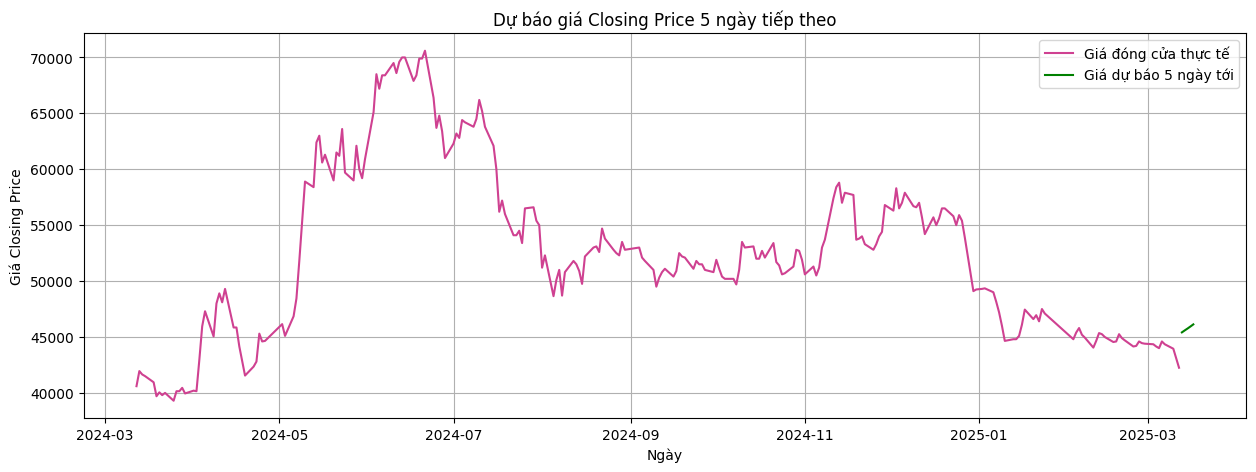

In [50]:
# Bước 1: Lấy 50 ngày gần nhất (Closing Price) để predict
last_50_days = data[-50:].values  # data là tập Closing Price ban đầu của bạn
last_50_days_scaled = scaler.transform(last_50_days)  # scale theo scaler cũ

# Bước 2: Chuẩn bị input cho model
X_predict = last_50_days_scaled.reshape(1, 50, 1)

# Bước 3: Dự báo liên tiếp 10 ngày
future_predictions = []

for _ in range(5):  # Dự báo 5 ngày
    pred_price = model.predict(X_predict)
    future_predictions.append(pred_price[0, 0])

    # Cập nhật X_predict: bỏ giá cũ, thêm giá mới vào cuối
    X_predict = np.append(X_predict[:, 1:, :], pred_price.reshape(1, 1, 1), axis=1)

# Bước 4: Inverse scale về giá thực tế
future_predictions = np.array(future_predictions).reshape(-1, 1)
future_predictions_real = scaler.inverse_transform(future_predictions)

# Bước 5: Tạo DataFrame kết quả
last_date = data.index[-1]
future_dates = pd.date_range(last_date + pd.Timedelta(days=1), periods=5)

future_df = pd.DataFrame(future_predictions_real, index=future_dates, columns=['Predicted Closing Price'])

print(future_df)

# Bước 6: Vẽ biểu đồ
plt.figure(figsize=(15,5))
plt.plot(data.index, data['Closing Price'], label='Giá đóng cửa thực tế')
plt.plot(future_df.index, future_df['Predicted Closing Price'], label='Giá dự báo 5 ngày tới', color='green')
plt.title('Dự báo giá Closing Price 5 ngày tiếp theo')
plt.xlabel('Ngày')
plt.ylabel('Giá Closing Price')
plt.legend()
plt.grid()
plt.show()

In [37]:
# Lấy index ngày từ DataFrame gốc
date_index = data.index

# Xác định ngày tương ứng cho tập test
test_index = date_index[training_data_len:]

# Khớp độ dài với y_test_predict
test_index = test_index[-len(y_test_predict):]

# Tạo DataFrame kết quả
compare_df = pd.DataFrame({
    'Actual Closing Price': y_test.values.flatten(),
    'Predicted Closing Price': y_test_predict.flatten()
}, index=test_index)

# Xem vài dòng đầu tiên
compare_df

,Actual Closing Price,Predicted Closing Price
Date,,
2024-12-25,55900,56262.062500
2024-12-26,55400,56203.312500
2024-12-27,53900,56120.210938
2024-12-30,49100,55894.542969
2024-12-31,49250,55189.523438
2025-01-02,49300,54355.000000
2025-01-03,49350,53527.683594
2025-01-06,49000,52775.507812
2025-01-07,48150,52093.109375


In [38]:
import yfinance as yf
import datetime as dt

update_date = dt.datetime.now().strftime('%Y-%m-%d')
CMG_quote = yf.download('CMG', start='2025-03-13', end=update_date)

# Tạo khung dữ liệu mới
CMG_quote.columns = CMG_quote.columns.get_level_values(0)
CMG_quote.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Date,,,,,
2025-03-13,48.730000,50.020000,48.220001,49.950001,12552500
2025-03-14,50.029999,50.250000,49.119999,50.080002,13840300
2025-03-17,49.650002,50.230000,49.290001,50.009998,10426200
2025-03-18,47.790001,49.330002,47.549999,49.330002,17984500
2025-03-19,48.990002,49.090000,47.750000,47.750000,16346600


In [39]:
# Lấy đúng cột Closing Price (giá đóng cửa) để khớp với mô hình ban đầu
new_data = CMG_quote[['Close']].copy()
new_data.columns = ['Closing Price']

# Nếu cần chuyển chỉ mục Date về dạng datetime (cho chắc)
new_data.index = pd.to_datetime(new_data.index)

In [40]:
new_data = new_data['Closing Price']*1000
new_data

Date
2025-03-13    48729.999542
2025-03-14    50029.998779
2025-03-17    49650.001526
2025-03-18    47790.000916
2025-03-19    48990.001678
2025-03-20    49000.000000
2025-03-21    48529.998779
2025-03-24    49599.998474
2025-03-25    49509.998322
2025-03-26    50069.999695
2025-03-27    50919.998169
2025-03-28    49909.999847
2025-03-31    50209.999084
2025-04-01    51669.998169
2025-04-02    52020.000458
2025-04-03    50080.001831
2025-04-04    47290.000916
2025-04-07    46669.998169
2025-04-08    45979.999542
2025-04-09    50930.000305
2025-04-10    50270.000458
2025-04-11    49759.998322
2025-04-14    49459.999084
2025-04-15    48799.999237
2025-04-16    48080.001831
2025-04-17    48169.998169
2025-04-21    46529.998779
2025-04-22    47099.998474
2025-04-23    48759.998322
2025-04-24    49540.000916
2025-04-25    51779.998779
2025-04-28    50900.001526
2025-04-29    50650.001526
2025-04-30    50520.000458
2025-05-01    50319.999695
2025-05-02    51560.001373
2025-05-05    50009.998

In [41]:
full_data = pd.concat([data, new_data])

full_data = full_data.sort_index()

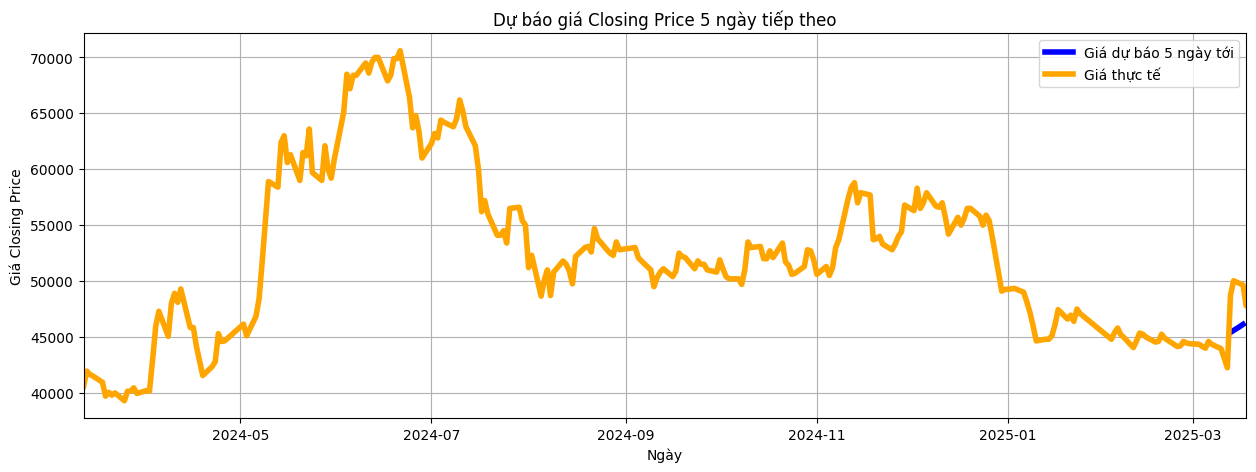

In [67]:
import pandas as pd

# Chuyển end_date thành kiểu datetime
end_date = pd.to_datetime('2025-03-18')

# Bước 6: Vẽ biểu đồ
plt.figure(figsize=(15,5))
plt.plot(future_df.index, future_df['Predicted Closing Price'], label='Giá dự báo 5 ngày tới', linewidth=4, color='blue')
plt.plot(full_data.index, full_data['Closing Price'], label='Giá thực tế', linewidth=4, color='orange')
plt.title('Dự báo giá Closing Price 5 ngày tiếp theo')
plt.xlabel('Ngày')
plt.ylabel('Giá Closing Price')

# Giới hạn phạm vi trục X từ ngày bắt đầu đến ngày bạn chỉ định (end_date)
plt.xlim(full_data.index[0], end_date)  # Giới hạn ngày từ start của future_df đến end_date

plt.legend()
plt.grid()
plt.show()

In [43]:
full_data

,Closing Price
Date,
2024-03-12,40600.000000
2024-03-13,41950.000000
2024-03-14,41650.000000
2024-03-15,41500.000000
2024-03-18,40950.000000
...,...
2025-05-01,50319.999695
2025-05-02,51560.001373
2025-05-05,50009.998322


# Retrain lại mô hình giúp tối ưu hóa mô hình

In [44]:
# Bước 1: Chuẩn bị dữ liệu đầu vào
data_values = full_data['Closing Price'].values.reshape(-1, 1)

# Bước 2: Scale dữ liệu
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_values)

# Bước 3: Tạo tập train (lookback = 50 ngày)
def create_dataset(dataset, lookback=50):
    X, y = [], []
    for i in range(lookback, len(dataset)):
        X.append(dataset[i-lookback:i])
        y.append(dataset[i])
    return np.array(X), np.array(y)

X_train, y_train = create_dataset(scaled_data)

# Bước 4: Reshape đầu vào cho LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

# Bước 5: Khởi tạo và huấn luyện lại mô hình
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(50, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.fit(X_train, y_train, epochs=30, batch_size=16, verbose=1)

c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.2068
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0442
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0173
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0126
Epoch 5/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0114
Epoch 6/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0106
Epoch 7/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0091
Epoch 8/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0097
Epoch 9/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0097
Epoch 10/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.0090
Epoch 11/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0081
Epoch 12/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0108
Epoch 13/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0088
Epoch 14/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0088
Epoch 15/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0087
Epoc

# DỰ BÁO 3 NGÀY TIẾP THEO SAU TOÀN BỘ DỮ LIỆU

In [45]:
# Bước 1: Lấy 50 ngày cuối cùng làm input
last_50 = scaled_data[-50:]
X_input = last_50.reshape((1, 50, 1))

# Bước 2: Dự báo liên tiếp 3 ngày
predictions = []

for _ in range(3):
    pred = model.predict(X_input, verbose=0)
    predictions.append(pred[0, 0])
    X_input = np.append(X_input[:, 1:, :], pred.reshape(1, 1, 1), axis=1)

# Bước 3: Inverse scale
predicted_prices = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Bước 4: Tạo ngày tương ứng
last_date = full_data.index[-1]
future_dates = pd.date_range(last_date + pd.Timedelta(days=1), periods=3)

# Bước 5: Tạo DataFrame kết quả
next3_df = pd.DataFrame(predicted_prices, index=future_dates, columns=['Predicted Closing Price'])

next3_df

,Predicted Closing Price
2025-05-08,50990.222656
2025-05-09,51101.996094
2025-05-10,51217.535156


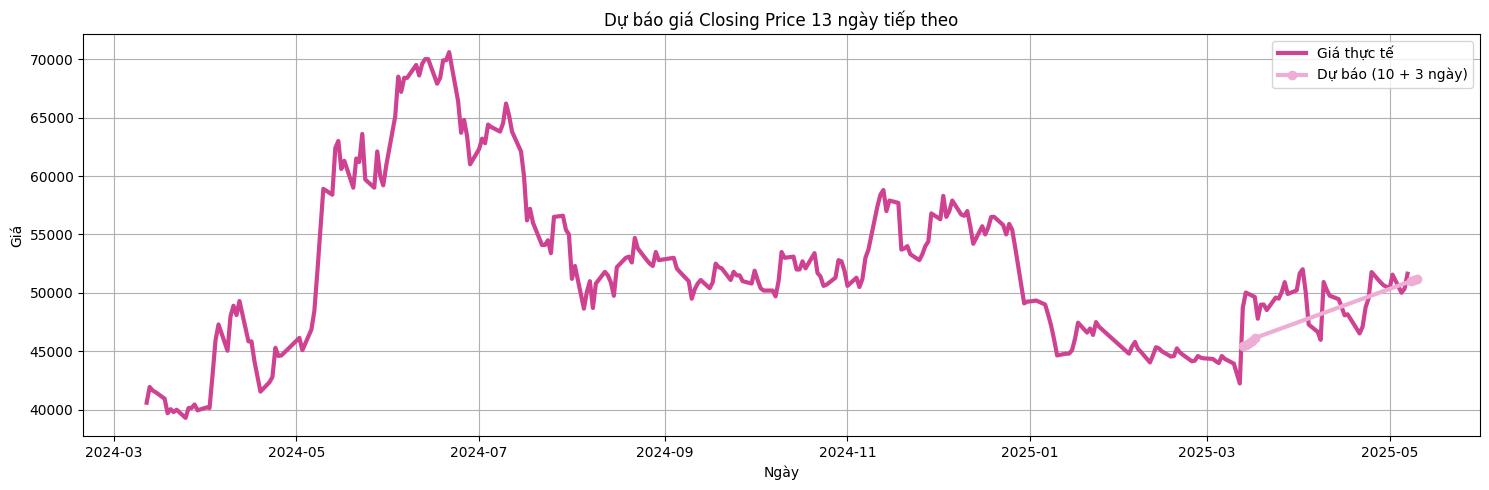

In [46]:
combined_forecast = pd.concat([future_df, next3_df])

plt.figure(figsize=(15,5))
plt.plot(full_data.index, full_data['Closing Price'], label='Giá thực tế', linewidth=3)
plt.plot(combined_forecast.index, combined_forecast['Predicted Closing Price'],
         label='Dự báo (10 + 3 ngày)', linewidth = 3, marker='o')
plt.title('Dự báo giá Closing Price 13 ngày tiếp theo')
plt.xlabel('Ngày')
plt.ylabel('Giá')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [47]:
real_data = full_data[['Closing Price']].copy()

# Ghép dữ liệu thực và dữ liệu dự báo vào bảng
full_combined_data = pd.concat([real_data, combined_forecast], axis=1)

full_combined_data

,Closing Price,Predicted Closing Price
2024-03-12,40600.00000,NaN
2024-03-13,41950.00000,NaN
2024-03-14,41650.00000,NaN
2024-03-15,41500.00000,NaN
2024-03-18,40950.00000,NaN
...,...,...
2025-05-06,50360.00061,NaN
2025-05-07,51639.99939,NaN
2025-05-08,NaN,50990.222656
2025-05-09,NaN,51101.996094


In [48]:
full_combined_data.to_csv('Du_bao_CMG.csv', index=True)